## SetUp

Python version required: 3.7 or higher \\
Training should be done on GPU A100

In [ ]:
# !pip install keras-ocr Use this library if using python<3.10

In [1]:
!pip install -q image-ocr
!pip install -q imgaug
!pip install -q -U opencv-python # We need the most recent version of OpenCV.
!pip install -q ipykernel --upgrade
%tensorflow_version 2.x

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 64.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.24.0 which is incompatible.
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/University/Magistrale/Thesis/notebook

Mounted at /gdrive
/gdrive/My Drive/University/Magistrale/Thesis/C3


In [ ]:
#import keras_ocr


In [3]:
import image_ocr

In [4]:
import zipfile
import datetime
import string
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import typing
import string

import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import hashlib

import urllib.request
import urllib.parse

alphabet = string.digits + '/'
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
tf.__version__
data_dir = '.'
#alphabet = string.digits +  '/'
#recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
#recognizer_alphabet = string.digits + '/'
'''
ORIGINAL
alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
'''
# FORSE MEGLIO SOLO NUMERI


"\nORIGINAL\nalphabet = string.digits + string.ascii_letters + '!?. '\nrecognizer_alphabet = ''.join(sorted(set(alphabet.lower())))\n"

## Create Custom Dataset

In order to train on our own model, we first take a look at the required structure of image generator needed for training. The generator is composed by the pair (image,lines) where lines is structured in the following way:

### Identifying the structure


In [ ]:
lines

### Retrieving images
We then retrieve images. Since finding Credit Cards dataset results really difficult, we will firstly try to download some of them by Google Images with a script

In [ ]:
! pip install google_images_download
'''
If error, a temporary fix is:
edit the ./google_images_download/google_images_download.py file
and change
"info = data[11]" to "info = data[23]"
'''

from google_images_download import google_images_download   #importing the library

response = google_images_download.googleimagesdownload()   #class instantiation

arguments = {"keywords":"Polar bears,baloons,Beaches","limit":20,"print_urls":True}   #creating list of arguments
paths = response.download(arguments)   #passing the arguments to the function
print(paths)   #printing absolute paths of the downloaded images

In [ ]:
import os
from PIL import Image

img_dir = r"data"
for filename in os.listdir(img_dir):
    try :
        with Image.open(img_dir + "/" + filename) as im:
             print('ok')
    except :
        print(img_dir + "/" + filename)
        os.remove(img_dir + "/" + filename)

In [ ]:
! googleimagesdownload --keywords "credit, card" --limit 20


/bin/bash: googleimagesdownload: command not found


### Label the images

Once we have them we need to label the images, once again trying to fit the structure needed.
It is ([box position clockwise order], Value of char) pair.
We will use labelme (https://github.com/wkentaro/labelme) tool to make it simpler and then take the json result file and manipulate it for our purpose.

In [ ]:
import json
import base64
import numpy as np
import cv2

with open('2.visaclassiccredit-400x225.json', 'r') as f:
    data = json.load(f)

shapes = []
for shape in data["shapes"]:
    points = np.array(shape["points"], dtype=np.float32)
    label = shape["label"]
    shapes.append([(points, label)])

print(shapes)

# decode image data
img_data = base64.b64decode(data['imageData'])

# load image from decoded data
img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)

[[(array([[ 31.78392 , 119.53518 ],
       [330.27637 , 117.02261 ],
       [332.0352  , 150.94221 ],
       [ 30.276382, 153.20352 ]], dtype=float32), '400123456789010')], [(array([[143.09045, 162.24875],
       [200.37688, 161.74623],
       [200.62814, 183.35428],
       [142.58794, 183.10301]], dtype=float32), '12/24')]]


Now lets try to read it like we did before with the auto-generated images

The first generated validation image (below) contains: 400123456789010
12/24


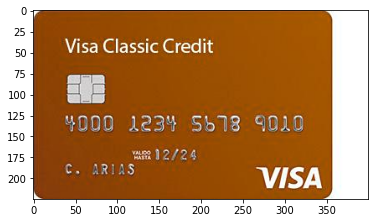

In [ ]:
text = keras_ocr.data_generation.convert_lines_to_paragraph(shapes)
print('The first generated validation image (below) contains:', text)
plt.imshow(img)

### Generator

We then need a method to put these images in a generator:

In [5]:
import os
import glob
import json
import base64
import numpy as np
import cv2
from operator import length_hint
def custom_dataset_generator(directory_path="data/train", batch_size=1,len=4):
    # Get a list of all JSON files in the directory
    json_files = glob.glob(os.path.join(directory_path, "*.json"))

    # Iterate through each JSON file
    while True:
        np.random.shuffle(json_files)

        for json_file in json_files:
            with open(json_file, 'r') as f:
                data = json.load(f)

            shapes = []
            x = []
            c = 0
            if (length_hint(data["shapes"])==21):
              for shape in data["shapes"]:
                  c += 1
                  points = np.array(shape["points"], dtype=np.float32)
                  length = points.shape[0]
                  #print(length)
                  if length == 2:
                      # Add other two points to make it a rectangle in clockwise order
                      x1, y1 = points[0]
                      x2, y2 = points[1]
                      points = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.float32)
                  label = shape["label"]
                  x.append((points, label))

                  if (c %len==0 and c<20) or c == 21:
                      shapes.append(x)
                      x = []
              # Decode image data
              img_data = base64.b64decode(data['imageData'])

              # Load image from decoded data
              img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)

              # Check if image width is odd
              if img.shape[1] % 2 != 0:
                  # If width is odd, reduce it by 1
                  img = img[:, :-1]

              # Check if image height is odd
              if img.shape[0] % 2 != 0:
                  # If height is odd, reduce it by 1
                  img = img[:-1, :]

              yield img, shapes


### Generator with augmentation

In [6]:
import os
import glob
import json
import base64
import numpy as np
import cv2

def custom_dataset_generator_augmented(directory_path="data/train", batch_size=1, augmented_fact=4, len=4):
    # get a list of all JSON files in the directory
    json_files = glob.glob(os.path.join(directory_path, "*.json"))

    # iterate through each JSON file
    while True:
        np.random.shuffle(json_files)
        for json_file in json_files:
            if directory_path != "data/test":
                with open(json_file, 'r') as f:
                    data = json.load(f)

                shapes = []
                c = 0
                x = []
                if (length_hint(data["shapes"])==21):
                  for shape in data["shapes"]:
                      c += 1
                      points = np.array(shape["points"], dtype=np.float32)
                      length = points.shape[0]
                      if length == 2:
                          # add other two points to make it a rectangle in a clockwise order
                          x1, y1 = points[0]
                          x2, y2 = points[1]
                          points = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.float32)
                      label = shape["label"]
                      x.append((points, label))

                      if (c % len == 0 and c < 20) or c == 21:
                          shapes.append(x)
                          x = []

                  # decode image data
                  img_data = base64.b64decode(data['imageData'])

                  # load image from decoded data
                  img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)
                  # Image width must be even
                  # Check if width is odd
                  if img.shape[1] % 2 != 0:
                      # If width is odd, reduce it by 1
                      img = img[:, :-1]
                  # Check if height is odd
                  if img.shape[0] % 2 != 0:
                      # If height is odd, reduce it by 1
                      img = img[:-1, :]

                  yield img, shapes

                  for i in range(augmented_fact):
                      augmented_img = []
                      augmented_shapes = []
                      x = []
                      c = 0
                      for shape in data["shapes"]:
                          c += 1
                          points = np.array(shape["points"], dtype=np.float32)
                          length = points.shape[0]
                          #print(length)
                          if length == 2:
                              # add other two points to make it a rectangle in a clockwise order
                              x1, y1 = points[0]
                              x2, y2 = points[1]
                              points = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.float32)
                          label = shape["label"]
                          x.append((points, label))

                          if (c % len == 0 and c < 20) or c == 21:
                              augmented_shapes.append(x)
                              x = []

                      # decode image data
                      img_data = base64.b64decode(data['imageData'])

                      # load image from decoded data
                      img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)
                      augment_type = np.random.choice(["color", "bw", "brightness", "contrast"])  # Randomly choose color augmentation type

                      if i == 0:
                          img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to black and white
                          img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert back to BGR
                      elif i == 1:
                          brightness_delta = np.random.randint(-50, 50)  # Random brightness delta
                          img = cv2.convertScaleAbs(img, alpha=1, beta=brightness_delta)  # Adjust brightness by adding a random value to each pixel
                      elif i == 2:
                          contrast_factor = np.random.uniform(0.5, 1.5)  # Random contrast factor
                          img = cv2.convertScaleAbs(img, alpha=contrast_factor, beta=0)  # Adjust contrast by multiplying each pixel value by a random factor
                      # Image width must be even
                      # Check if width is odd
                      if img.shape[1] % 2 != 0:
                          # If width is odd, reduce it by 1
                          img = img[:, :-1]
                      # Check if height is odd
                      if img.shape[0] % 2 != 0:
                          # If height is odd, reduce it by 1
                          img = img[:-1, :]
                      ### ROTATION

                      yield img,augmented_shapes
            else:
                with open(json_file, 'r') as f:
                    data = json.load(f)

                shapes = []
                c = 0
                x = []
                if (length_hint(data["shapes"])==21):
                  for shape in data["shapes"]:
                      c += 1
                      points = np.array(shape["points"], dtype=np.float32)
                      length = points.shape[0]
                      if length == 2:
                          # add other two points to make it a rectangle in a clockwise order
                          x1, y1 = points[0]
                          x2, y2 = points[1]
                          points = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.float32)
                      label = shape["label"]
                      x.append((points, label))

                      if (c % len == 0 and c < 20) or c == 21:
                          shapes.append(x)
                          x = []

                  # decode image data
                  img_data = base64.b64decode(data['imageData'])

                  # load image from decoded data
                  img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)
                  # Image width must be even
                  # Check if width is odd
                  if img.shape[1] % 2 != 0:
                      # If width is odd, reduce it by 1
                      img = img[:, :-1]
                  # Check if height is odd
                  if img.shape[0] % 2 != 0:
                      # If height is odd, reduce it by 1
                      img = img[:-1, :]

                  yield img, shapes


### An example

In [ ]:
image_generator=custom_dataset_generator_rec(directory_path="PAN_dataset/1")
#image_generator=custom_dataset_generator(directory_path="data/test")
#image_generator=custom_dataset_generator_augmented(directory_path="data/valid")

False
1
The first generated validation image (below) contains:
1


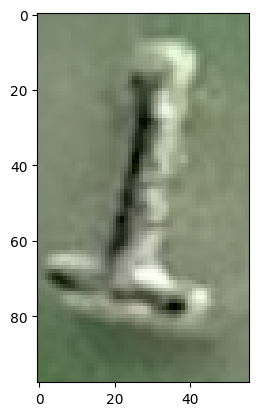

In [ ]:
# See what the first validation image looks like.


image, lines = next(image_generator)
text = image_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:')
print(text)
plt.imshow(image)

Now, as in the implementation example above, a list of image generators for train,test and validation is generated, in the following way:

Now we have our dataset consistent with the training input strucutre: we now pass it as training argument.

In [ ]:
'''
TO ADD IN ROTATION LINE FOR AUGMENTATION


                      # apply random rotation to image and shape coordinates
                      angle = np.random.randint(-10, 10)
                      rows, cols = img.shape[:2]
                      M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
                      img = cv2.warpAffine(img, M, (cols, rows))

                      rotated_shapes = []
                      for x in augmented_shapes:
                          rotated_x = []
                          for points, label in x:
                              points = np.hstack((points, np.ones((4, 1), dtype=np.float32)))
                              points = np.dot(M, points.T).T[:, :2]
                              rotated_x.append((points, label))
                          rotated_shapes.append(rotated_x)
                      yield img, rotated_shapes
'''

## Set-Up Generators

In [7]:
def count_json(folder_path = 'path/to/folder' ):
  json_count = 0
  json_files = glob.glob(os.path.join(folder_path, "*.json"))
    # Iterate through each JSON file
  while True:
        np.random.shuffle(json_files)

        for json_file in json_files:
            with open(json_file, 'r') as f:
                data = json.load(f)
            if (length_hint(data["shapes"])==21):
              json_count += 1
        return json_count

def count_json_total(folder_path = 'path/to/folder' ):
  json_count = 0

  for file_name in os.listdir(folder_path):
      if file_name.endswith('.json'):
          json_count += 1
  return json_count


In [241]:
import cv2
import random
import numpy as np

def augment_data(generator,aug=2):
    for image, text in generator:
        height, width = image.shape[:2]
        if "/" in text:
            yield cv2.resize(image, (width, height)), text
            image_parts = [image[:, i * split_width : (i + 1) * split_width, :] for i in range(5)]
            text_parts = [text[i] for i in range(5)]
            indices_ran = [0,1,3,4]
            for i in range(aug):
              random.shuffle(indices_ran)

              indices = [indices_ran[0],indices_ran[1],2,indices_ran[2],indices_ran[3]]
              shuffled_image_parts = [image_parts[i] for i in indices]
              shuffled_text_parts = [text_parts[i] for i in indices]
              # Concatenate the image parts back together
              augmented_image = cv2.hconcat(shuffled_image_parts)
              augmented_image = cv2.resize(augmented_image, (width, height))

              # Concatenate the text parts back together and swap corresponding numbers
              augmented_text = ''.join(shuffled_text_parts)

              yield augmented_image, augmented_text
        else:
            yield cv2.resize(image, (width, height)), text
            # Split the image into four parts
            split_width = width // 11
            image_parts = [image[:, i * split_width : (i + 1) * split_width, :] for i in range(4)]


           # plt.imshow(image)
            # Split the text into four parts (no further splitting needed)
            text_parts = [text[i] for i in range(4)]
            #print(text_parts)
            # Create a list of indices for shuffling
            indices = list(range(4))
            for i in range(aug):
              # Shuffle the indices
              random.shuffle(indices)
              if i<4:
                indices[0]=indices[i]
              #print(indices)
              # Rearrange the image and text parts using shuffled indices
              shuffled_image_parts = [image_parts[i] for i in indices]
              shuffled_text_parts = [text_parts[i] for i in indices]

              # Concatenate the image parts back together
              augmented_image = cv2.hconcat(shuffled_image_parts)
              augmented_image = cv2.resize(augmented_image, (width, height))

              # Concatenate the text parts back together and swap corresponding numbers
              augmented_text = ''.join(shuffled_text_parts)

              yield augmented_image, augmented_text


After defining



In [237]:
augmented_factor=1
recognition_aug=3
len=4
detector_batch_size = 1
max_length = 5
recognition_batch_size =  5*(recognition_aug+1)
#image_generators = [ custom_dataset_generator_rec(directory_path=data_path,batch_size=detector_batch_size)  for data_path in ["PAN_dataset/train","PAN_dataset/valid","PAN_dataset/test"]]

image_generators = [ custom_dataset_generator(directory_path=data_path,batch_size=detector_batch_size)  for data_path in ["data/train","data/valid","data/test"]]
#image_generators = [ custom_dataset_generator_augmented(directory_path=data_path,batch_size=detector_batch_size,augmented_fact=augmented_factor,len=len)  for data_path in ["data/train","data/valid","data/test"]]

In [204]:
#DETECTOR
#detector = image_ocr.detection.Detector(weights='clovaai_general')
detector =image_ocr.detection.Detector()
detector.model.load_weights('detector_custom_model.h5')
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]


Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [238]:
#RECOGNIZER
recognizer = image_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan',
)
recognizer.compile()


Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [239]:
for layer in recognizer.backbone.layers:
    layer.trainable = False

In [240]:
recognition_image_generators = [
    image_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

In [242]:
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recognition_test_generator = [
    recognizer.get_batch_generator(
    image_generator=augment_data(image_generator,recognition_aug),
    batch_size=recognition_batch_size,
    lowercase=True
    ) for image_generator in recognition_image_generators
]

### Example

The first generated validation image (below) contains: 6228
8910
2888
8888
88/88


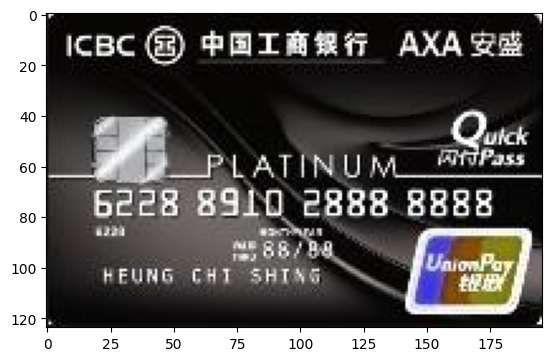

In [95]:
# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = image_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [154]:
recognition_image_generator = augment_data(recognition_image_generators[1])

This image contains: 1234


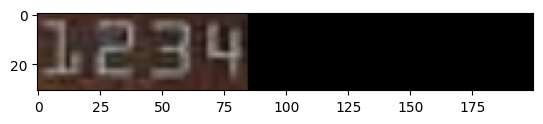

In [174]:
# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generator)
print('This image contains:', text)
plt.imshow(image)


In [ ]:
image.shape

(31, 200, 3)

## Train

### Detector

In [ ]:
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=count_json("data/train")*augmented_factor,
    epochs=300,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=count_json("data/valid")*augmented_factor,
    batch_size=detector_batch_size
)

Epoch 1/300
161/161 [==============================] - 397s 2s/step - loss: 0.0066 - val_loss: 0.0137
Epoch 2/300
161/161 [==============================] - 16s 101ms/step - loss: 0.0035 - val_loss: 0.0176
Epoch 3/300
161/161 [==============================] - 19s 117ms/step - loss: 0.0028 - val_loss: 0.0165
Epoch 4/300
161/161 [==============================] - 16s 102ms/step - loss: 0.0019 - val_loss: 0.0103
Epoch 5/300
161/161 [==============================] - 16s 97ms/step - loss: 0.0021 - val_loss: 0.0146
Epoch 6/300
161/161 [==============================] - 13s 80ms/step - loss: 0.0016 - val_loss: 0.0094
Epoch 7/300
161/161 [==============================] - 13s 82ms/step - loss: 0.0013 - val_loss: 0.0094
Epoch 8/300
161/161 [==============================] - 14s 86ms/step - loss: 0.0012 - val_loss: 0.0165
Epoch 9/300
161/161 [==============================] - 12s 75ms/step - loss: 0.0012 - val_loss: 0.0125
Epoch 10/300
161/161 [==============================] - 15s 91ms/step -

### Recognition

In [ ]:
recognizer.training_model.fit(
    recognition_train_generator,
    steps_per_epoch=math.ceil((count_json("data/train")*5*(recognition_aug+1))/ recognition_batch_size),
    epochs=300,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=15),
        tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil((count_json("data/valid")*5*(recognition_aug+1))/ recognition_batch_size),
    batch_size=recognition_batch_size
)

Epoch 1/300
153/153 [==============================] - 54s 213ms/step - loss: 10.5488 - val_loss: 10.0491
Epoch 2/300
153/153 [==============================] - 29s 192ms/step - loss: 5.0430 - val_loss: 4.7189
Epoch 3/300
153/153 [==============================] - 29s 191ms/step - loss: 2.9867 - val_loss: 3.1973
Epoch 4/300
153/153 [==============================] - 29s 192ms/step - loss: 1.9083 - val_loss: 2.8306
Epoch 5/300
153/153 [==============================] - 30s 193ms/step - loss: 1.6424 - val_loss: 1.9324
Epoch 6/300
153/153 [==============================] - 30s 194ms/step - loss: 1.4560 - val_loss: 3.3298
Epoch 7/300
153/153 [==============================] - 29s 193ms/step - loss: 1.2313 - val_loss: 1.9216
Epoch 8/300
153/153 [==============================] - 29s 191ms/step - loss: 0.9775 - val_loss: 2.1999
Epoch 9/300
153/153 [==============================] - 29s 192ms/step - loss: 0.9928 - val_loss: 1.8042
Epoch 10/300
153/153 [==============================] - 29s 19

## Fine-Tuning

### Detector

In [ ]:
batch_size = 1
detector.model.fit_generator(
    generator=detection_train_generator,
    steps_per_epoch=math.ceil(count_json("data/train")*augmented_factor* / batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_icdar2013.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_icdar2013.h5'))
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(count_json("data/valid")*augmented_factor / batch_size)
)

Epoch 1/1000


<ipython-input-42-4146e4a1a91e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  detector.model.fit_generator(


161/161 [==============================] - 35s 124ms/step - loss: 0.0062 - val_loss: 0.0154
Epoch 2/1000
161/161 [==============================] - 16s 98ms/step - loss: 0.0034 - val_loss: 0.0171
Epoch 3/1000
161/161 [==============================] - 16s 98ms/step - loss: 0.0025 - val_loss: 0.0110
Epoch 4/1000
161/161 [==============================] - 16s 97ms/step - loss: 0.0020 - val_loss: 0.0120
Epoch 5/1000
161/161 [==============================] - 13s 79ms/step - loss: 0.0019 - val_loss: 0.0126
Epoch 6/1000
161/161 [==============================] - 19s 118ms/step - loss: 0.0018 - val_loss: 0.0097
Epoch 7/1000
161/161 [==============================] - 11s 70ms/step - loss: 0.0017 - val_loss: 0.0111
Epoch 8/1000
161/161 [==============================] - 12s 78ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 9/1000
161/161 [==============================] - 12s 76ms/step - loss: 0.0025 - val_loss: 0.0077
Epoch 10/1000
161/161 [==============================] - 13s 84ms/step - lo

### Recognizer


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit_generator(
    generator=recognition_train_generator,
    steps_per_epoch=math.ceil((count_json("data/train")*augmented_factor* (21/max_length))/ recognition_batch_size),
    validation_steps=math.ceil((count_json("data/valid")*augmented_factor* (21/max_length))/ recognition_batch_size),
    validation_data=recognition_val_generator,
    callbacks=callbacks,
    epochs=1000,
)

Epoch 1/1000


<ipython-input-95-20c85bf3c04d>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  recognizer.training_model.fit_generator(


85/85 [==============================] - 25s 136ms/step - loss: 11.5405 - val_loss: 9.0025
Epoch 2/1000
85/85 [==============================] - 8s 93ms/step - loss: 7.6417 - val_loss: 6.9690
Epoch 3/1000
85/85 [==============================] - 9s 104ms/step - loss: 6.1969 - val_loss: 5.2518
Epoch 4/1000
85/85 [==============================] - 8s 92ms/step - loss: 5.0065 - val_loss: 6.2237
Epoch 5/1000
85/85 [==============================] - 10s 113ms/step - loss: 4.5117 - val_loss: 5.0554
Epoch 6/1000
85/85 [==============================] - 9s 112ms/step - loss: 4.1430 - val_loss: 3.9914
Epoch 7/1000
85/85 [==============================] - 8s 93ms/step - loss: 3.3259 - val_loss: 3.3303
Epoch 8/1000
85/85 [==============================] - 9s 104ms/step - loss: 3.1827 - val_loss: 3.6611
Epoch 9/1000
85/85 [==============================] - 8s 97ms/step - loss: 2.4226 - val_loss: 4.0793
Epoch 10/1000
85/85 [==============================] - 9s 105ms/step - loss: 2.4692 - val_loss: 

## Train only recognizer

### Generator for Recognition


In [ ]:
def count_png_total(folder_path = 'path/to/folder' ):
  json_count = 0

  for file_name in os.listdir(folder_path):
      if file_name.endswith('.png'):
          json_count += 1
  return json_count

In [ ]:
import os
import glob
import json
import base64
import cv2
import numpy as np
from sklearn.utils import shuffle

def custom_dataset_generator_rec(directory_path, group_size=4,augmentation_fact=3):
    # Get a list of all image files in the directory
    image_files = glob.glob(os.path.join(directory_path, "*.png"))
  # iterate through each JSON file
    while True:
      # Iterate through the image files in groups of four
      for i in range(0, count_png_total(directory_path) - group_size + 1, group_size):
          image_batch_files = image_files[i:i+4]  # Get the next four image files
          shapes = []
          images = []
          labels = []
          max_height = 0  # Maximum height among the images in the group
          total_width = 0  # Total width of all images in the group

          for image_file in image_batch_files:
              image_name = os.path.basename(image_file)
              label = image_name[0]  # Extract the first character of the image name as the label

              with open(image_file, 'rb') as f:
                  img_data = f.read()

              img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)

              # Check if image width is odd
              if img.shape[1] % 2 != 0:
                  # If width is odd, reduce it by 1
                  img = img[:, :-1]

              # Check if image height is odd
              if img.shape[0] % 2 != 0:
                  # If height is odd, reduce it by 1
                  img = img[:-1, :]
              max_height = max(max_height, img.shape[0])  # Update the maximum height
              total_width += img.shape[1]  # Update the total width

              points = np.array([[0, 0], [img.shape[1], 0], [img.shape[1], img.shape[0]], [0, img.shape[0]]],
                                dtype=np.float32)  # Vertices of the original image
              shapes.append((points, label))
              images.append(img)
            # Calculate the desired width based on the maximum height and aspect ratio
          # Calculate the desired width based on the maximum height and aspect ratio
          desired_width = int((max_height / img.shape[0]) * img.shape[1])

          # Resize the images to have the same width and height
          resized_images = []
          for img in images:
              img = cv2.resize(img, (desired_width, max_height))
              resized_images.append(img)
          import random

          # Concatenate the images horizontally
          img_batch = np.concatenate(resized_images, axis=1)

          # Calculate the scaling factors
          scale_width = img_batch.shape[1] / total_width
          scale_height = img_batch.shape[0] / max_height

          # Resize the points based on the scaled image
          resized_shapes = []
          offset_x = 0
          for shape, label in shapes:
              resized_points = shape * np.array([scale_width, scale_height])
              resized_points[:, 0] += offset_x
              resized_points[:, 1] *= scale_height  # Adjust the y-coordinate based on the scaled image height
              resized_shapes.append((resized_points, label))
              offset_x += shape[1, 0] * scale_width
          ok=[]
          ok.append(resized_shapes)

          # Concatenate the images horizontally

          yield img_batch, ok # Return the concatenated image and its corresponding shape as a batch
          for i in range(0,augmentation_fact):
            if i%5==0 and i>0:
              resized_images[3]=resized_images[0]
              shapes[3]=shapes[0]
            resized_images, shapes = shuffle(resized_images, shapes, random_state=0)

  # Concatenate the images horizontally
            img_batch = np.concatenate(resized_images, axis=1)

            # Calculate the scaling factors
            scale_width = img_batch.shape[1] / total_width
            scale_height = img_batch.shape[0] / max_height

            # Resize the points based on the scaled image
            resized_shapes = []
            offset_x = 0
            for shape, label in shapes:
                resized_points = shape * np.array([scale_width, scale_height])
                resized_points[:, 0] += offset_x
                resized_points[:, 1] *= scale_height  # Adjust the y-coordinate based on the scaled image height
                resized_shapes.append((resized_points, label))
                offset_x += shape[1, 0] * scale_width
            ok=[]
            ok.append(resized_shapes)
            yield img_batch, ok # Return the concatenated image and its corresponding shape as a batch



### Train

In [ ]:
augmented_factor=1
len=30
detector_batch_size = 1
max_length = 4
recognition_batch_size = 1
augmentation_factor=15
image_generators = [ custom_dataset_generator_rec(directory_path=data_path,augmentation_fact=augmentation_factor-1)  for data_path in ["PAN_dataset/train","PAN_dataset/valid","PAN_dataset/test"]]
recognition_batch_size=4

The first generated validation image (below) contains: 5224


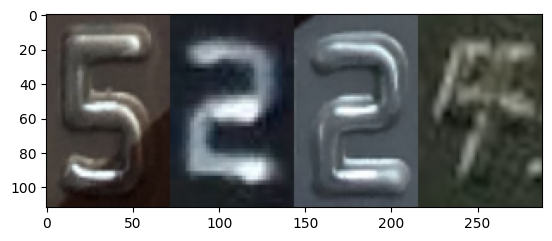

In [ ]:
# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = image_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [ ]:
alphabet = string.digits + string.ascii_lowercase
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

In [ ]:
#RECOGNIZER
recognizer = image_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan',
)
recognizer.compile()


Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [ ]:
for layer in recognizer.backbone.layers:
    layer.trainable = False

In [ ]:
recognition_image_generators = [
    image_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recognition_test_generator = [
    recognizer.get_batch_generator(
    image_generator=image_generator,
    batch_size=recognition_batch_size,
    lowercase=True
    ) for image_generator in recognition_image_generators
]


This image contains: 3396


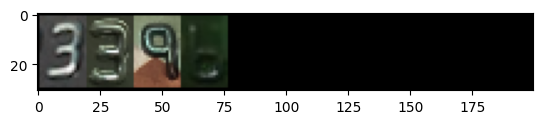

In [ ]:
# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [ ]:
def get_generator_length(generator):
    length = 0
    for _ in generator:
        print(length)
        length += 1
    return length

In [ ]:
recognizer.training_model.fit(
    recognition_train_generator,
    steps_per_epoch=math.ceil(count_png_total("PAN_dataset/train")*augmentation_factor/ recognition_batch_size),
    epochs=300,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10),
        tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(count_png_total("PAN_dataset/valid")*augmentation_factor/ recognition_batch_size),
    batch_size=recognition_batch_size

)

Epoch 1/300
2280/2280 [==============================] - 157s 69ms/step - loss: 1.0351 - val_loss: 2.9635
Epoch 2/300
2280/2280 [==============================] - 150s 66ms/step - loss: 0.2121 - val_loss: 3.2503
Epoch 3/300
2280/2280 [==============================] - 149s 65ms/step - loss: 0.1453 - val_loss: 3.9496
Epoch 4/300
2280/2280 [==============================] - 148s 65ms/step - loss: 0.0981 - val_loss: 3.7029
Epoch 5/300
2280/2280 [==============================] - 148s 65ms/step - loss: 0.0702 - val_loss: 3.8576
Epoch 6/300
2280/2280 [==============================] - 149s 65ms/step - loss: 0.0648 - val_loss: 3.4836
Epoch 7/300
2280/2280 [==============================] - 149s 66ms/step - loss: 0.0515 - val_loss: 3.8301
Epoch 8/300
2280/2280 [==============================] - 149s 65ms/step - loss: 0.0531 - val_loss: 4.4373
Epoch 9/300
2280/2280 [==============================] - 148s 65ms/step - loss: 0.0481 - val_loss: 4.1650
Epoch 10/300
2280/2280 [======================

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
hystory = recognizer.training_model.fit_generator(
    generator=recognition_train_generator,
    steps_per_epoch=math.ceil(count_png_total("PAN_dataset/train")*augmentation_factor/ recognition_batch_size),
    validation_steps=math.ceil(count_png_total("PAN_dataset/valid")*augmentation_factor/ recognition_batch_size),
    validation_data=recognition_val_generator,
    callbacks=callbacks,
    epochs=1000,

)

Epoch 1/1000
2280/2280 [==============================] - ETA: 0s - loss: 1.4413

2280/2280 [==============================] - 165s 72ms/step - loss: 1.4413 - val_loss: 13.2567
Epoch 2/1000
2280/2280 [==============================] - ETA: 0s - loss: 1.2427

2280/2280 [==============================] - 164s 72ms/step - loss: 1.2427 - val_loss: 12.6207
Epoch 3/1000
2280/2280 [==============================] - ETA: 0s - loss: 1.0439

2280/2280 [==============================] - 162s 71ms/step - loss: 1.0439 - val_loss: 11.7337
Epoch 4/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.8860

2280/2280 [==============================] - 162s 71ms/step - loss: 0.8860 - val_loss: 13.2240
Epoch 5/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.8017

2280/2280 [==============================] - 162s 71ms/step - loss: 0.8017 - val_loss: 13.2631
Epoch 6/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.7082

2280/2280 [==============================] - 162s 71ms/step - loss: 0.7082 - val_loss: 13.6693
Epoch 7/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.6703

2280/2280 [==============================] - 164s 72ms/step - loss: 0.6703 - val_loss: 12.5772
Epoch 8/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.6727

2280/2280 [==============================] - 161s 71ms/step - loss: 0.6727 - val_loss: 14.7540
Epoch 9/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.6500

2280/2280 [==============================] - 160s 70ms/step - loss: 0.6500 - val_loss: 13.4286
Epoch 10/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.5506

2280/2280 [==============================] - 161s 71ms/step - loss: 0.5506 - val_loss: 12.2149
Epoch 11/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.4856

2280/2280 [==============================] - 162s 71ms/step - loss: 0.4856 - val_loss: 12.4259
Epoch 12/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.4228

2280/2280 [==============================] - 161s 70ms/step - loss: 0.4228 - val_loss: 13.1661
Epoch 13/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.4380

2280/2280 [==============================] - 168s 74ms/step - loss: 0.4380 - val_loss: 13.8933
Epoch 14/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.4062

2280/2280 [==============================] - 166s 73ms/step - loss: 0.4062 - val_loss: 13.6744
Epoch 15/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.3960

2280/2280 [==============================] - 164s 72ms/step - loss: 0.3960 - val_loss: 13.1097
Epoch 16/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.3853

2280/2280 [==============================] - 163s 72ms/step - loss: 0.3853 - val_loss: 11.7670
Epoch 17/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.3363

2280/2280 [==============================] - 163s 71ms/step - loss: 0.3363 - val_loss: 13.4453
Epoch 18/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.3299

2280/2280 [==============================] - 163s 72ms/step - loss: 0.3299 - val_loss: 15.4732
Epoch 19/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.3249

2280/2280 [==============================] - 160s 70ms/step - loss: 0.3249 - val_loss: 14.0392
Epoch 20/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.3401

2280/2280 [==============================] - 162s 71ms/step - loss: 0.3401 - val_loss: 12.0954
Epoch 21/1000
2280/2280 [==============================] - ETA: 0s - loss: 0.3135

2280/2280 [==============================] - 160s 70ms/step - loss: 0.3135 - val_loss: 14.3762
Epoch 22/1000
1795/2280 [======================>.......] - ETA: 28s - loss: 0.3035

KeyboardInterrupt: ignored

In [ ]:
print(hystory.history['loss'])  # List of training loss values
print(hystory.history['accuracy'])  # List of training accuracy values

[8.984161376953125, 6.430997848510742, 4.28843355178833, 3.147878646850586, 2.408517360687256, 1.8893908262252808]


KeyError: ignored

In [ ]:
#DETECTOR
#detector = image_ocr.detection.Detector(weights='clovaai_general')
detector =image_ocr.detection.Detector()
detector.model.load_weights('detector_custom_model.h5')
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]


Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [ ]:
image_generators = [ custom_dataset_generator(directory_path=data_path,batch_size=detector_batch_size)  for data_path in ["data/train","data/valid","data/test"]]


## Inference

In [ ]:
pipeline = image_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)


In [ ]:
image, lines = next(image_generators[2])
predictions = pipeline.recognize(images=[image])[0]
drawn = image_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions]
)
plt.imshow(drawn)

## Save

Te aim is to save the prediction model and then convert in TFLite. In order to do this we save the new weights and then load them in the model.

In [ ]:
recognizer.prediction_model.save_weights('recognizer_custom_model_v4.h5')

In [ ]:
recognizer.model.load_weights('recognizer_custom_model.h5')


In [ ]:
detector.model.save_weights('detector_custom_model.h5')

In [ ]:
detector.model.load_weights('detector_custom_model.h5')

## Convert to TFLite

## TFLITE Conversion

In [ ]:
# Download and unzipping representative dataset TODO ONCE
##%%bash
#wget https://github.com/tulasiram58827/ocr_tflite/raw/main/data/represent_data.zip
#unzip represent_data.zip

Archive:  represent_data.zip


--2023-06-18 10:02:42--  https://github.com/tulasiram58827/ocr_tflite/raw/main/data/represent_data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tulasiram58827/ocr_tflite/main/data/represent_data.zip [following]
--2023-06-18 10:02:42--  https://raw.githubusercontent.com/tulasiram58827/ocr_tflite/main/data/represent_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585568 (572K) [application/zip]
Saving to: ‘represent_data.zip.1’

     0K .......... .......... .......... .......... ..........  8% 18.3M 0s
    50K .......... .......... .......... .......... .......... 17% 26.8M 0s

CalledProcessError: ignored

In [ ]:
dataset_path = 'represent_data/'
def representative_data_gen():
    for file in os.listdir(dataset_path):
        image_path = dataset_path + file
        input_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        input_data = cv2.resize(input_data, (200, 31))
        input_data = input_data[np.newaxis]
        input_data = np.expand_dims(input_data, 3)
        input_data = input_data.astype('float32')/255
        yield [input_data]

In [ ]:
dataset_path = 'data/test'
def representative_data_gen():
    for file in os.listdir(dataset_path):
        image_path = dataset_path + file
        input_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        input_data = cv2.resize(input_data, (200, 31))
        input_data = input_data[np.newaxis]
        input_data = np.expand_dims(input_data, 3)
        input_data = input_data.astype('float32')/255
        yield [input_data]

In [ ]:
def convert_tflite(quantization,prediction_model,name=""):
    converter = tf.lite.TFLiteConverter.from_keras_model(prediction_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
    if quantization == 'float16':
        converter.target_spec.supported_types = [tf.float16]
    elif quantization == 'int8' or quantization == 'full_int8':
        converter.representative_dataset = representative_data_gen
    if quantization == 'full_int8':
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8  # or tf.uint8
        converter.inference_output_type = tf.int8  # or tf.uint8
    tf_lite_model = converter.convert()
    open(f'ocr_{name}{quantization}.tflite', 'wb').write(tf_lite_model)

**Note** : Support for CTC Decoder is not available in TFLite yet. So while converting we removed CTCDecoder in model part. We need to run Decoder from the output of the model.

Refer to this [issue](https://github.com/tensorflow/tensorflow/issues/33494) regarding CTC decoder support in TFLite.

**Update** : CTC Decoder is supported in TFLite now by enabling Built-in-Ops in Tensorflow 2.4. Thanks to TensorFlow team for the support.

**Detector conversion**

In [ ]:
quantization = 'int8' #@param ["dr", "float16","int8","full_int8"]
convert_tflite(quantization,detector.model,name="detector_")

AttributeError: ignored

**Recognizer conversion**

In [ ]:
quantization = 'dr' #@param ["dr", "float16","int8","full_int8"]
convert_tflite(quantization,recognizer.prediction_model,name="recognize_")

In [ ]:
!du -sh ocr_dr.tflite

8.5M	ocr_dr.tflite


In [ ]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tmpdir = tempfile.mkdtemp()
mobilenet_save_path = os.path.join(tmpdir, "detector/1/")
tf.saved_model.save(detector.model, mobilenet_save_path)

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(mobilenet_save_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:

import tensorflow as tf

model = tf.keras.models.load_model('detector_custom_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

ValueError: ignored

**Currently Integer Quantization is erroring out and informed to TFLite team**

## TFLite Inference

In [ ]:
def run_tflite_model(image_path, quantization):
    input_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print(input_data.shape)

    input_data = cv2.resize(input_data, (200, 31))
    input_data = input_data[np.newaxis]
    input_data = np.expand_dims(input_data, 3)
    input_data = input_data.astype('float32')/255
    path = f'keras_ocr_{quantization}_ctc.tflite'
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    return output

In [ ]:
from google.colab.patches import cv2_imshow
image_path = 'represent_data/word_2.png'
image_path = 'img/images.png'

In [ ]:
DEFAULT_BUILD_PARAMS = {
    'height': 31,
    'width': 200,
    'color': False,
    'filters': (64, 128, 256, 256, 512, 512, 512),
    'rnn_units': (128, 128),
    'dropout': 0.25,
    'rnn_steps_to_discard': 2,
    'pool_size': 2,
    'stn': True,
}

DEFAULT_ALPHABET = string.digits + string.ascii_lowercase

PRETRAINED_WEIGHTS = {
    'kurapan': {
        'alphabet': DEFAULT_ALPHABET,
        'build_params': DEFAULT_BUILD_PARAMS,
        'weights': {
            'notop': {
                'url':
                'https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/crnn_kurapan_notop.h5',
                'filename': 'crnn_kurapan_notop.h5',
                'sha256': '027fd2cced3cbea0c4f5894bb8e9e85bac04f11daf96b8fdcf1e4ee95dcf51b9'
            },
            'top': {
                'url':
                'https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/crnn_kurapan.h5',
                'filename': 'crnn_kurapan.h5',
                'sha256': 'a7d8086ac8f5c3d6a0a828f7d6fbabcaf815415dd125c32533013f85603be46d'
            }
        }
    }
}
build_params = DEFAULT_BUILD_PARAMS
alphabets = DEFAULT_ALPHABET
blank_index = len(alphabets)

(123, 188)



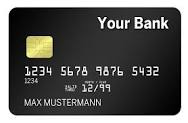

In [ ]:
# Running Dynamic Range Quantization
tflite_output = run_tflite_model(image_path, 'dr')
final_output = "".join(alphabets[index] for index in tflite_output[0] if index not in [blank_index, -1])
print(final_output)
cv2_imshow(cv2.imread(image_path))

In [ ]:
# Running Float16 Quantization
tflite_output = run_tflite_model(image_path, 'dr')
final_output = "".join(alphabets[index] for index in tflite_output[0] if index not in [blank_index, -1])
print(final_output)
cv2_imshow(cv2.imread(image_path))

error: ignored

In [ ]:
# Running Integer Quantization
tflite_output = run_tflite_model(image_path, 'int8')
final_output = "".join(alphabets[index] for index in decoded[0] if index not in [blank_index, -1])
print(final_output)
cv2_imshow(cv2.imread(image_path))

**The above code snippet will error out as informed integer quantization is not yet supported**

## Dynamic Range Model benchmarks

**Inference Time** : 0.2sec

**Memory FootPrint** : 46.38MB

**Model Size** : 8.5MB

## Float16 benchmarks

**Inference** : 0.76sec

**Memory FootPrint** : 128MB

**Model Size** : 17MB

**The above benchmarks with respect to Redmi K20 Pro with 4 threads. **

## Detector to TFLite


In [ ]:
import torch

In [ ]:
!pip install onnx
!pip install git+https://github.com/onnx/onnx-tensorflow.git
!pip uninstall torchvision
!pip install torchvision==0.13
import onnx
import numpy as np
import os
import cv2
import time


import torch
from torch.autograd import Variable

from skimage import io
import tensorflow as tf
from onnx_tf.backend import prepare
from google.colab.patches import cv2_imshow

ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/onnx/onnx-tensorflow.git to /tmp/pip-req-build-42orgzpm
  Running command git clone --filter=blob:none --quiet https://github.com/onnx/onnx-tensorflow.git /tmp/pip-req-build-42orgzpm
  Resolved https://github.com/onnx/onnx-tensorflow.git to commit ee0c5e537b3cebbddc5773871e6786e6468c7f3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 36.9 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Found existing installation: torchvision 0.15.2+cu118
Uninstalling torchvision-0.15.2+cu118:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchvision-0.15.2+cu118.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libcudart.60cfec8e.so.11.0
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.10

ModuleNotFoundError: ignored

## s

In [ ]:
import gdown

import numpy as np

from pathlib import Path
from datetime import datetime


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.backends.cudnn as cudnn
from torchvision import models
from torchvision.models.vgg import model_urls
from collections import namedtuple
from collections import OrderedDict
import onnx
import onnxruntime
from onnx_tf.backend import prepare


ModuleNotFoundError: ignored

In [ ]:
import torch
import torch.nn as nn
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def init_weights(modules):
    for m in modules:
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
class vgg16_bn(torch.nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(vgg16_bn, self).__init__()
        model_urls['vgg16_bn'] = model_urls['vgg16_bn'].replace('https://', 'http://')
        vgg_pretrained_features = models.vgg16_bn(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(12):         # conv2_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 19):         # conv3_3
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(19, 29):         # conv4_3
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(29, 39):         # conv5_3
            self.slice4.add_module(str(x), vgg_pretrained_features[x])

        # fc6, fc7 without atrous conv
        self.slice5 = torch.nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
                nn.Conv2d(1024, 1024, kernel_size=1)
        )

        if not pretrained:
            init_weights(self.slice1.modules())
            init_weights(self.slice2.modules())
            init_weights(self.slice3.modules())
            init_weights(self.slice4.modules())

        init_weights(self.slice5.modules())        # no pretrained model for fc6 and fc7

        if freeze:
            for param in self.slice1.parameters():      # only first conv
                param.requires_grad= False
    def forward(self, X):
        h = self.slice1(X)
        h_relu2_2 = h
        h = self.slice2(h)
        h_relu3_2 = h
        h = self.slice3(h)
        h_relu4_3 = h
        h = self.slice4(h)
        h_relu5_3 = h
        h = self.slice5(h)
        h_fc7 = h
        vgg_outputs = namedtuple("VggOutputs", ['fc7', 'relu5_3', 'relu4_3', 'relu3_2', 'relu2_2'])
        out = vgg_outputs(h_fc7, h_relu5_3, h_relu4_3, h_relu3_2, h_relu2_2)
        return out

class double_conv(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch + mid_ch, mid_ch, kernel_size=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:

class CRAFT(nn.Module):
    def __init__(self, pretrained=False, freeze=False):
        super(CRAFT, self).__init__()

        """ Base network """
        self.basenet = vgg16_bn(pretrained, freeze)

        """ U network """
        self.upconv1 = double_conv(1024, 512, 256)
        self.upconv2 = double_conv(512, 256, 128)
        self.upconv3 = double_conv(256, 128, 64)
        self.upconv4 = double_conv(128, 64, 32)

        num_class = 2
        self.conv_cls = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, num_class, kernel_size=1),
        )

        init_weights(self.upconv1.modules())
        init_weights(self.upconv2.modules())
        init_weights(self.upconv3.modules())
        init_weights(self.upconv4.modules())
        init_weights(self.conv_cls.modules())

    def forward(self, x):
        """ Base network """
        sources = self.basenet(x)

        """ U network """
        y = torch.cat([sources[0], sources[1]], dim=1)
        y = self.upconv1(y)

        y = F.interpolate(y, size=sources[2].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[2]], dim=1)
        y = self.upconv2(y)

        y = F.interpolate(y, size=sources[3].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[3]], dim=1)
        y = self.upconv3(y)
        y = F.interpolate(y, size=sources[4].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[4]], dim=1)
        feature = self.upconv4(y)

        y = self.conv_cls(feature)

        return y.permute(0,2,3,1), feature

In [ ]:
torch.save(net.state_dict(), 'saved')

## f

In [ ]:
net = CRAFT()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

net.load_state_dict(copyStateDict(torch.load('craft_mlt_25k.pth', map_location='cpu')))
#net.load_state_dict(copyStateDict(torch.load('.EasyOCR/model/craft_mlt_25k.pth', map_location='cuda')))
#net = torch.nn.DataParallel(net).to('cuda')
#cudnn.benchmark = False
print("Model loaded")
net.eval()
batch_size = 1
# Input to the model
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True)
onnx_runtime_input = x.detach().numpy()
t1 = datetime.now()
torch_out = net(x)
t2 = datetime.now()
print("Time taken for Pytoch model", str(t2-t1))
store_out = torch_out[0].detach().numpy()
print("Output size", torch_out[0].size())
print("Model ran sucesfully")

Model loaded
Time taken for Pytoch model 0:00:01.070738
Output size torch.Size([1, 112, 112, 2])
Model ran sucesfully


In [ ]:
dataset_path = 'image_files/'

In [ ]:
torch.save(net, 'models/model.pt')

In [ ]:
loaded = torch.load('models/model.pt')

In [ ]:
concrete_func = loaded.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

concrete_func.inputs[0].set_shape([None, 3, 800, 600])

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

converter.optimizations = [tf.lite.Optimize.DEFAULT]

AttributeError: ignored